In [2]:
MY_UNIQNAME = 'yuqin'

In [3]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import spacy
import os
from os import path
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter
from wordcloud import WordCloud
import pathlib
import json

# Filter all warnings.
import warnings
warnings.filterwarnings('ignore')

# loading up the language model: English
nlp = spacy.load('en')

In [4]:
# Use X_train, X_test, y_train, y_test for all of the following questions
from sklearn.model_selection import train_test_split

df = pd.read_csv('training.csv',encoding='latin-1',names=['polarity','id','date','query','user','text'])
df = df.iloc[790000:810001,:]
df.polarity.unique()

array([0, 4])

In [5]:
document = df['text']

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

def text_clean(book_text):
    
    # Convert to lowercase
    text_low = book_text.lower()
    
    # Remove punctuation and any other non-alphabet characters
    text_low_no_num = re.sub(r'[0-9]', '', text_low)
    
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~''' # list of special characters you want to exclude
    text_low_no_num_no_punc = ""
    for char in text_low_no_num:
        if char not in punctuations:
            text_low_no_num_no_punc = text_low_no_num_no_punc + char
            
    clean_text = text_low_no_num_no_punc.replace(os.linesep, "")
    
    # stop words
    text_nonstop = ""
    words = clean_text.split()
    for word in words:
        if word not in STOP_WORDS:
            text_nonstop = text_nonstop + " " + word 
    
    return text_nonstop


In [7]:

tfidf_vectorizer = TfidfVectorizer(
    max_df=0.8, max_features=200000,
    min_df=0.2, stop_words='english',
    use_idf=True, tokenizer=text_clean, ngram_range=(1,3)
)

%time tfidf_matrix = tfidf_vectorizer.fit_transform(document)

print(tfidf_matrix.shape)

CPU times: user 1.62 s, sys: 44 ms, total: 1.66 s
Wall time: 1.66 s
(20001, 65)


In [8]:
from sklearn.metrics.pairwise import cosine_similarity
%time dist = 1 - cosine_similarity(tfidf_matrix)

CPU times: user 15.9 s, sys: 3.81 s, total: 19.7 s
Wall time: 19.7 s


CPU times: user 48.8 s, sys: 5 s, total: 53.8 s
Wall time: 18.5 s


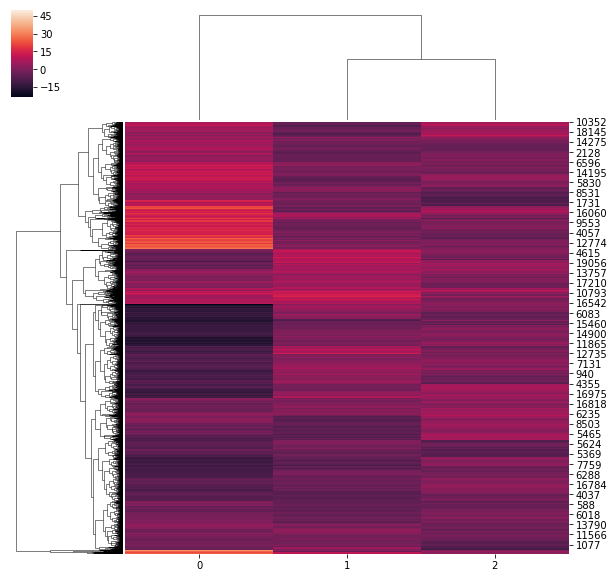

In [9]:
from sklearn.decomposition import PCA
%time reduced_data = PCA(n_components=3).fit_transform(dist)
# # Use seaborn's .clustermap() function to draw a hierarchically-clustered heatmap
sns.clustermap(reduced_data)

In [10]:
from sklearn import metrics
from sklearn.cluster import KMeans

# Insert your code here

# Rule of Thumb 
k = np.sqrt(30000/2)
print(k)

122.47448713915891


(1, 19.85)

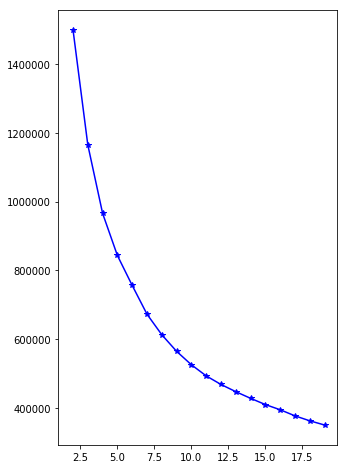

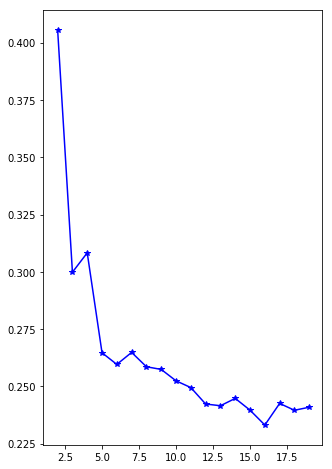

In [11]:
# two different cost functions 
# elbow
elbow_score = []
sihouette_score = []
for k in range(2,20):
    k_means = KMeans(init='k-means++', n_clusters=k, n_init=5)
    k_means.fit(reduced_data)
    elbow_score.append(k_means.inertia_)
    sihouette_score.append(metrics.silhouette_score(reduced_data, k_means.labels_))
    
score = pd.DataFrame()
score['elbow'] = elbow_score
score['sihouette'] = sihouette_score

score
fig, ax = plt.subplots()
fig.set_size_inches(5,8)
plt.plot(range(2,20), score['elbow'], 'b*-')
plt.xlim(1, plt.xlim()[1])

fig, ax = plt.subplots()
fig.set_size_inches(5,8)
plt.plot(range(2,20), score['sihouette'], 'b*-')
plt.xlim(1, plt.xlim()[1])

(1, 19.85)

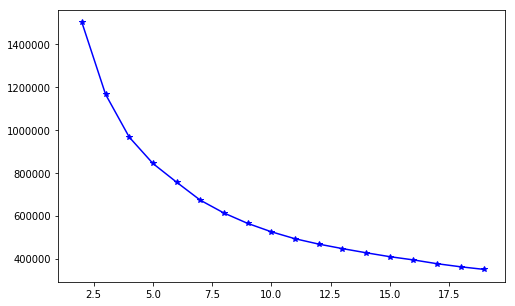

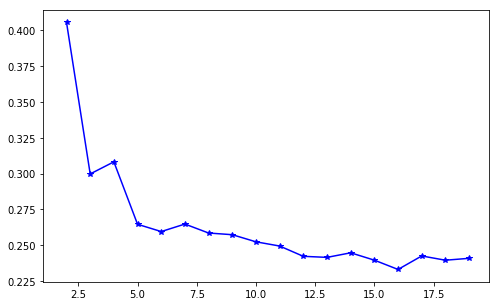

In [12]:
score
fig, ax = plt.subplots()
fig.set_size_inches(8,5)
plt.plot(range(2,20), score['elbow'], 'b*-')
plt.xlim(1, plt.xlim()[1])

fig, ax = plt.subplots()
fig.set_size_inches(8,5)
plt.plot(range(2,20), score['sihouette'], 'b*-')
plt.xlim(1, plt.xlim()[1])

In [13]:
# Enter your code here
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(reduced_data)

from scipy.cluster.hierarchy import fcluster
fcluster = fcluster(linkage_matrix, 3, criterion='maxclust')

In [14]:
i = 0
cluster_list = []
for cluster in fcluster:
    cluster_list.append((i,cluster))
    i +=1

In [20]:
document = df['text']

In [25]:
document.iloc[0]

"Virpi's last day.  Busy as tits."

In [38]:
one = ""
two = ""
three = ""
for item in cluster_list:
    tweet=text_clean(document.iloc[item[0]])
    if item[-1] == 1:
        one = one + tweet
    if item[-1] == 2:
        two = two + tweet
    if item[-1] == 3:
        three = three + tweet

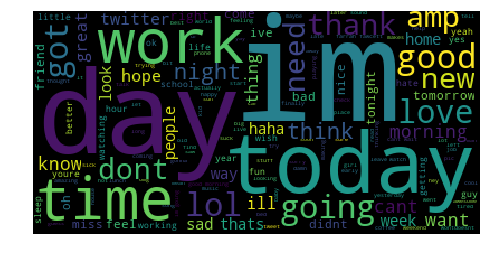

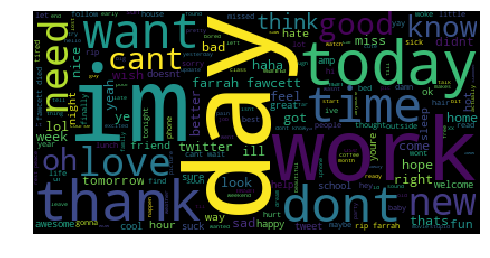

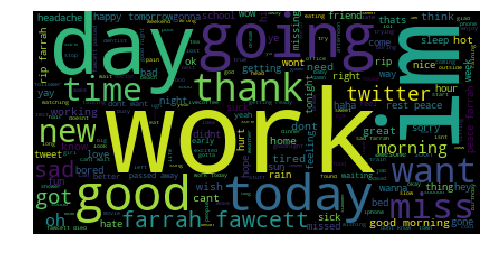

In [27]:
for cluster in [one,two,three]:
    wordcloud = WordCloud().generate(cluster)
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud)
    plt.axis("off")   
    plt.show()

In [28]:
# one pos tag
from collections import Counter
one_counts = Counter(one.split()).most_common(100)
one_counts[50:100]

[('nice', 193),
 ('long', 191),
 ('farrah', 190),
 ('days', 187),
 ('youre', 186),
 ('looking', 184),
 ('gonna', 181),
 ('fun', 178),
 ('wait', 175),
 ('happy', 175),
 ('yeah', 171),
 ('having', 170),
 ('little', 167),
 ('school', 160),
 ('thing', 157),
 ('yes', 155),
 ('bed', 153),
 ('feeling', 152),
 ('look', 151),
 ('life', 149),
 ('fawcett', 149),
 ('ok', 148),
 ('soon', 147),
 ('watching', 147),
 ('old', 141),
 ('sure', 139),
 ('trying', 138),
 ('hate', 136),
 ('actually', 134),
 ('best', 134),
 ('things', 131),
 ('away', 128),
 ('hey', 127),
 ('ready', 126),
 ('big', 126),
 ('man', 125),
 ('watch', 124),
 ('glad', 124),
 ('wont', 123),
 ('hours', 122),
 ('friends', 121),
 ('find', 120),
 ('maybe', 120),
 ('x', 120),
 ('guys', 120),
 ('try', 118),
 ('stuff', 117),
 ('help', 117),
 ('awesome', 116),
 ('cool', 114)]

In [29]:
one_nlp = nlp(one[:800000])
one_noun = list()
one_ad = list()
one_verb = list()
for i, sent in enumerate(one_nlp.sents):
    for token in sent:
        if token.pos_ == 'NOUN':
            one_noun.append(str(token))
        if token.pos_ == 'VERB':
            one_verb.append(str(token))
        if token.pos_ == 'ADJ':
            one_ad.append(str(token))

In [30]:
# Counter is useful for string
one_pos_count = pd.DataFrame()
one_noun_counts = Counter(one_noun).most_common(50)
one_pos_count['noun']=one_noun_counts
one_ad_counts = Counter(one_ad).most_common(50)
one_pos_count['adj'] = one_ad_counts
one_verb_counts = Counter(one_verb).most_common(50)
one_pos_count['verb'] = one_verb_counts
one_pos_count

,noun,adj,verb
0,"(day, 737)","(good, 927)","(m, 1529)"
1,"(today, 694)","(new, 365)","(going, 648)"
2,"(time, 527)","(great, 302)","(s, 623)"
3,"(work, 489)","(sad, 262)","(got, 609)"
4,"(morning, 453)","(ill, 261)","(do, 556)"
5,"(night, 383)","(bad, 223)","(ca, 495)"
6,"(love, 346)","(nice, 193)","(know, 425)"
7,"(amp, 303)","(that, 188)","(think, 382)"
8,"(thanks, 292)","(happy, 174)","(ve, 298)"
9,"(twitter, 249)","(little, 160)","(want, 291)"


In [31]:
# two pos tag
two_counts = Counter(two.split()).most_common(100)
# two_counts[50:100]
two_counts[0:50]

[('im', 258),
 ('day', 224),
 ('dont', 200),
 ('work', 196),
 ('cant', 190),
 ('today', 183),
 ('like', 177),
 ('farrah', 159),
 ('know', 151),
 ('good', 142),
 ('love', 128),
 ('thanks', 126),
 ('need', 125),
 ('want', 124),
 ('time', 123),
 ('oh', 122),
 ('sad', 119),
 ('new', 119),
 ('fawcett', 115),
 ('got', 111),
 ('twitter', 105),
 ('lol', 105),
 ('think', 103),
 ('miss', 98),
 ('thats', 96),
 ('u', 95),
 ('haha', 88),
 ('hope', 87),
 ('sorry', 87),
 ('feel', 86),
 ('home', 85),
 ('bad', 82),
 ('yes', 79),
 ('nice', 78),
 ('better', 76),
 ('days', 73),
 ('wish', 72),
 ('rip', 70),
 ('didnt', 67),
 ('ill', 66),
 ('happy', 65),
 ('right', 61),
 ('yeah', 61),
 ('tomorrow', 60),
 ('fun', 60),
 ('sleep', 58),
 ('come', 53),
 ('died', 52),
 ('wait', 50),
 ('way', 50)]

In [32]:
two_nlp = nlp(two)
two_noun = list()
two_ad = list()
two_verb = list()
for i, sent in enumerate(two_nlp.sents):
    for token in sent:
        if token.pos_ == 'NOUN':
            two_noun.append(str(token))
        if token.pos_ == 'VERB':
            two_verb.append(str(token))
        if token.pos_ == 'ADJ':
            two_ad.append(str(token))

In [33]:
two_pos_count = pd.DataFrame()
two_noun_counts = Counter(two_noun).most_common(50)
two_pos_count['noun']=two_noun_counts
two_ad_counts = Counter(two_ad).most_common(50)
two_pos_count['adj'] = two_ad_counts
two_verb_counts = Counter(two_verb).most_common(50)
two_pos_count['verb'] = two_verb_counts
two_pos_count

,noun,adj,verb
0,"(day, 224)","(good, 138)","(m, 265)"
1,"(today, 183)","(new, 119)","(do, 200)"
2,"(work, 161)","(sad, 118)","(ca, 190)"
3,"(farrah, 157)","(bad, 80)","(s, 169)"
4,"(thanks, 125)","(nice, 78)","(know, 143)"
5,"(time, 123)","(that, 76)","(got, 123)"
6,"(fawcett, 115)","(happy, 65)","(want, 114)"
7,"(love, 102)","(ill, 58)","(think, 100)"
8,"(twitter, 97)","(sorry, 52)","(need, 84)"
9,"(days, 72)","(better, 49)","(feel, 83)"


In [34]:
# three pos tag
three_counts = Counter(three.split()).most_common(100)
# three_counts[50:100]
three_counts[0:50]

[('work', 235),
 ('im', 227),
 ('good', 199),
 ('going', 142),
 ('farrah', 134),
 ('morning', 130),
 ('today', 129),
 ('day', 117),
 ('sad', 109),
 ('miss', 100),
 ('want', 100),
 ('dont', 93),
 ('fawcett', 83),
 ('time', 81),
 ('oh', 72),
 ('new', 72),
 ('got', 72),
 ('thanks', 71),
 ('twitter', 71),
 ('know', 69),
 ('cant', 62),
 ('home', 60),
 ('working', 58),
 ('getting', 56),
 ('hot', 49),
 ('night', 47),
 ('wish', 47),
 ('rip', 46),
 ('think', 46),
 ('tired', 45),
 ('great', 45),
 ('need', 45),
 ('tomorrow', 43),
 ('thats', 41),
 ('thank', 41),
 ('rest', 38),
 ('wanna', 37),
 ('days', 36),
 ('away', 36),
 ('u', 35),
 ('yay', 35),
 ('love', 35),
 ('gonna', 34),
 ('right', 34),
 ('peace', 34),
 ('sick', 33),
 ('like', 32),
 ('feel', 31),
 ('ready', 30),
 ('didnt', 29)]

In [35]:
three_nlp = nlp(three)
three_noun = list()
three_ad = list()
three_verb = list()
for i, sent in enumerate(three_nlp.sents):
    for token in sent:
        if token.pos_ == 'NOUN':
            three_noun.append(str(token))
        if token.pos_ == 'VERB':
            three_verb.append(str(token))
        if token.pos_ == 'ADJ':
            three_ad.append(str(token))

In [36]:
three_pos_count = pd.DataFrame()
three_noun_counts = Counter(three_noun).most_common(50)
three_pos_count['noun']=three_noun_counts
three_ad_counts = Counter(three_ad).most_common(50)
three_pos_count['adj'] = three_ad_counts
three_verb_counts = Counter(three_verb).most_common(50)
three_pos_count['verb'] = three_verb_counts
three_pos_count

,noun,adj,verb
0,"(work, 211)","(good, 197)","(m, 227)"
1,"(farrah, 134)","(sad, 109)","(going, 142)"
2,"(morning, 130)","(new, 72)","(do, 93)"
3,"(today, 129)","(hot, 47)","(want, 92)"
4,"(day, 117)","(tired, 43)","(got, 81)"
5,"(fawcett, 83)","(great, 43)","(miss, 76)"
6,"(time, 81)","(sick, 33)","(s, 76)"
7,"(thanks, 70)","(ready, 30)","(know, 67)"
8,"(twitter, 66)","(bored, 26)","(ca, 62)"
9,"(night, 47)","(happy, 26)","(working, 58)"


In [39]:
def topic_tweets(cluster,topic,number):
    one_nlp = nlp(cluster)
    rain = " "
    one_noun = list()
    one_ad = list()
    one_verb = list()
    for i, sent in enumerate(one_nlp.sents):
        for token in sent:
            if str(token) == topic:
                rain = rain + str(sent)
    rain_nlp = nlp(rain)
    rain_noun = list()
    rain_ad = list()
    rain_verb = list()
    for i, sent in enumerate(rain_nlp.sents):
        for token in sent:
            if token.pos_ == 'NOUN':
                rain_noun.append(str(token))
            if token.pos_ == 'VERB':
                rain_verb.append(str(token))
            if token.pos_ == 'ADJ':
                rain_ad.append(str(token))
    rain_pos_count = pd.DataFrame()
    rain_noun_counts = Counter(rain_noun).most_common(number)
    rain_pos_count['noun']=rain_noun_counts
    rain_ad_counts = Counter(rain_ad).most_common(number)
    rain_pos_count['adj'] = rain_ad_counts
    rain_verb_counts = Counter(rain_verb).most_common(number)
    rain_pos_count['verb'] = rain_verb_counts
    return rain_pos_count

In [40]:
rain = topic_tweets(one,'rain',20)
rain

,noun,adj,verb
0,"(rain, 63)","(good, 20)","(got, 18)"
1,"(today, 21)","(hot, 10)","(m, 17)"
2,"(time, 18)","(ill, 10)","(did, 17)"
3,"(work, 16)","(bad, 9)","(miss, 11)"
4,"(day, 16)","(new, 8)","(ca, 10)"
5,"(night, 11)","(sad, 8)","(s, 10)"
6,"(amp, 10)","(heavy, 6)","(going, 9)"
7,"(way, 8)","(little, 5)","(do, 9)"
8,"(morning, 7)","(great, 5)","(need, 8)"
9,"(farrah, 7)","(poor, 5)","(think, 8)"


In [41]:
rain_two = topic_tweets(two,'rain',20)
rain_two

,noun,adj,verb
0,"(rain, 15)","(new, 3)","(ca, 6)"
1,"(day, 8)","(bad, 3)","(do, 3)"
2,"(time, 5)","(happy, 3)","(know, 3)"
3,"(work, 5)","(better, 3)","(ve, 3)"
4,"(days, 5)","(right, 2)","(feel, 2)"
5,"(pain, 4)","(sick, 2)","(wish, 2)"
6,"(tomorrow, 3)","(omg, 2)","(want, 2)"
7,"(home, 3)","(sad, 2)","(sucks, 2)"
8,"(wish, 3)","(httptwitpiccomdee, 1)","(stay, 2)"
9,"(man, 2)","(reformat, 1)","(could, 2)"


In [42]:
rain_three = topic_tweets(three,'rain',20)
rain_three

,noun,adj,verb
0,"(rain, 30)","(good, 11)","(going, 19)"
1,"(work, 29)","(hot, 7)","(do, 13)"
2,"(day, 13)","(sad, 7)","(want, 11)"
3,"(today, 11)","(bad, 5)","(got, 8)"
4,"(head, 6)","(tired, 4)","(getting, 8)"
5,"(farrah, 6)","(ready, 4)","(m, 8)"
6,"(home, 6)","(right, 3)","(wants, 6)"
7,"(week, 5)","(sooooo, 3)","(come, 6)"
8,"(time, 5)","(busy, 3)","(feel, 5)"
9,"(wish, 5)","(hungry, 3)","(seen, 5)"


In [43]:
weekend = topic_tweets(one,'weekend',20)
weekend

,noun,adj,verb
0,"(weekend, 81)","(good, 33)","(going, 27)"
1,"(day, 30)","(long, 15)","(got, 26)"
2,"(work, 24)","(ill, 12)","(ca, 21)"
3,"(today, 22)","(ready, 10)","(do, 19)"
4,"(time, 21)","(new, 10)","(m, 18)"
5,"(night, 16)","(bad, 9)","(looking, 17)"
6,"(amp, 14)","(sick, 8)","(think, 14)"
7,"(tomorrow, 12)","(great, 8)","(know, 13)"
8,"(home, 11)","(awesome, 7)","(getting, 12)"
9,"(days, 11)","(that, 7)","(feel, 12)"


In [44]:
two_weekend = topic_tweets(two,'weekend',10)
two_weekend

,noun,adj,verb
0,"(weekend, 19)","(bad, 5)","(ca, 7)"
1,"(work, 5)","(sad, 4)","(know, 6)"
2,"(hope, 5)","(new, 4)","(want, 6)"
3,"(thanks, 4)","(fuck, 3)","(ve, 4)"
4,"(sleep, 3)","(excited, 3)","(wo, 3)"
5,"(day, 3)","(hot, 3)","(weekend, 3)"
6,"(miss, 3)","(sigh, 3)","(miss, 3)"
7,"(fawcett, 3)","(ugh, 2)","(m, 3)"
8,"(farrah, 3)","(tired, 2)","(feel, 3)"
9,"(plan, 3)","(goiiiiin, 2)","(heard, 3)"


In [45]:
three_weekend = topic_tweets(three,'weekend',20)
three_weekend

,noun,adj,verb
0,"(work, 14)","(new, 5)","(going, 9)"
1,"(weekend, 13)","(good, 4)","(do, 6)"
2,"(today, 8)","(ready, 3)","(got, 5)"
3,"(morning, 8)","(late, 3)","(m, 4)"
4,"(wish, 7)","(bad, 3)","(want, 4)"
5,"(twitter, 7)","(sweet, 3)","(working, 3)"
6,"(day, 6)","(nice, 2)","(s, 3)"
7,"(music, 6)","(sick, 2)","(talking, 3)"
8,"(homework, 5)","(whassup, 2)","(reading, 3)"
9,"(goodnight, 4)","(stephenpearne, 2)","(listening, 3)"


In [46]:
headache = topic_tweets(one,'headache',20)
headache

,noun,adj,verb
0,"(headache, 29)","(sad, 10)","(got, 13)"
1,"(day, 16)","(new, 10)","(m, 12)"
2,"(amp, 7)","(good, 10)","(woke, 7)"
3,"(today, 7)","(sick, 6)","(do, 7)"
4,"(hours, 6)","(bad, 5)","(ca, 6)"
5,"(work, 5)","(right, 4)","(wait, 6)"
6,"(farrah, 5)","(tired, 3)","(going, 5)"
7,"(morning, 4)","(cold, 3)","(think, 5)"
8,"(money, 4)","(better, 3)","(find, 5)"
9,"(home, 4)","(stupid, 3)","(know, 5)"


In [47]:
headache = topic_tweets(two,'headache',10)
headache

,noun,adj,verb
0,"(headache, 9)","(bad, 4)","(woke, 4)"
1,"(day, 4)","(sick, 2)","(got, 4)"
2,"(summer, 2)","(mrboutique, 1)","(think, 3)"
3,"(session, 2)","(sticky, 1)","(ca, 3)"
4,"(things, 2)","(new, 1)","(m, 2)"
5,"(oxfordgirl, 2)","(nikkipete, 1)","(gone, 2)"
6,"(work, 2)","(persiankiwi, 1)","(changed, 2)"
7,"(problem, 2)","(that, 1)","(came, 1)"
8,"(sway, 2)","(fuck, 1)","(starts, 1)"
9,"(fam, 1)","(xoxox, 1)","(shit, 1)"


In [48]:
headache = topic_tweets(three,'headache',20)
headache

,noun,adj,verb
0,"(headache, 43)","(new, 12)","(do, 19)"
1,"(work, 20)","(good, 12)","(know, 13)"
2,"(today, 9)","(sad, 9)","(want, 12)"
3,"(way, 6)","(ready, 5)","(feel, 10)"
4,"(days, 6)","(bored, 5)","(going, 10)"
5,"(dentist, 6)","(little, 5)","(miss, 9)"
6,"(home, 5)","(right, 4)","(getting, 8)"
7,"(iphone, 5)","(gutted, 4)","(raining, 8)"
8,"(sunshine, 5)","(best, 4)","(ca, 8)"
9,"(time, 4)","(nooooo, 4)","(working, 7)"


In [49]:
work = topic_tweets(one,'work',20)
work

,noun,adj,verb
0,"(work, 538)","(good, 177)","(got, 160)"
1,"(day, 177)","(new, 71)","(m, 135)"
2,"(today, 155)","(ill, 60)","(ca, 129)"
3,"(time, 115)","(sad, 58)","(do, 125)"
4,"(morning, 91)","(ready, 56)","(going, 121)"
5,"(night, 81)","(great, 49)","(work, 102)"
6,"(amp, 63)","(bad, 48)","(want, 101)"
7,"(thanks, 59)","(long, 41)","(getting, 85)"
8,"(hope, 55)","(little, 39)","(think, 78)"
9,"(home, 54)","(nice, 38)","(know, 77)"


In [50]:
work = topic_tweets(two,'work',20)
work

,noun,adj,verb
0,"(work, 196)","(new, 31)","(ca, 56)"
1,"(day, 57)","(sad, 31)","(do, 47)"
2,"(today, 49)","(bad, 16)","(want, 37)"
3,"(time, 29)","(beautiful, 16)","(got, 37)"
4,"(home, 27)","(good, 14)","(know, 33)"
5,"(love, 21)","(happy, 14)","(work, 32)"
6,"(farrah, 19)","(little, 13)","(m, 25)"
7,"(twitter, 17)","(tired, 13)","(need, 25)"
8,"(thanks, 17)","(sick, 12)","(feel, 23)"
9,"(school, 17)","(nice, 12)","(s, 23)"


In [51]:
work = topic_tweets(three,'work',20)
work

,noun,adj,verb
0,"(work, 388)","(good, 64)","(going, 91)"
1,"(today, 80)","(sad, 56)","(want, 75)"
2,"(day, 63)","(tired, 32)","(do, 73)"
3,"(farrah, 63)","(ready, 28)","(getting, 59)"
4,"(morning, 42)","(hot, 27)","(work, 53)"
5,"(fawcett, 39)","(sick, 25)","(got, 53)"
6,"(time, 36)","(new, 24)","(m, 46)"
7,"(home, 35)","(bad, 22)","(miss, 41)"
8,"(wish, 34)","(great, 19)","(working, 36)"
9,"(rain, 30)","(busy, 15)","(feel, 33)"


In [52]:
but = topic_tweets(one,'but',20)
but

,noun,adj,verb


In [53]:
but = topic_tweets(two,'but',20)
but

,noun,adj,verb


In [54]:
but = topic_tweets(three,'but',20)
but

,noun,adj,verb


In [55]:
night = topic_tweets(one,'night',20)
night

,noun,adj,verb
0,"(night, 423)","(good, 166)","(m, 93)"
1,"(day, 93)","(new, 57)","(going, 91)"
2,"(today, 87)","(great, 47)","(got, 84)"
3,"(time, 79)","(bad, 35)","(do, 56)"
4,"(morning, 77)","(ill, 28)","(ca, 51)"
5,"(work, 71)","(long, 28)","(think, 48)"
6,"(sleep, 56)","(happy, 26)","(know, 48)"
7,"(amp, 50)","(old, 26)","(want, 41)"
8,"(love, 44)","(nice, 25)","(s, 37)"
9,"(thanks, 40)","(sad, 21)","(need, 35)"


In [56]:
night = topic_tweets(two,'night',10)
night

,noun,adj,verb
0,"(night, 36)","(new, 10)","(got, 10)"
1,"(today, 12)","(good, 5)","(ca, 9)"
2,"(work, 7)","(sad, 4)","(do, 7)"
3,"(day, 7)","(bad, 3)","(m, 6)"
4,"(hope, 4)","(sorry, 3)","(did, 5)"
5,"(class, 4)","(awww, 3)","(think, 5)"
6,"(twitter, 4)","(right, 3)","(know, 5)"
7,"(love, 4)","(better, 3)","(need, 5)"
8,"(time, 4)","(lovely, 3)","(slept, 4)"
9,"(help, 3)","(ready, 2)","(want, 4)"


In [57]:
night = topic_tweets(three,'night',20)
night

,noun,adj,verb
0,"(night, 53)","(good, 43)","(going, 14)"
1,"(morning, 23)","(tired, 7)","(m, 8)"
2,"(thanks, 15)","(great, 7)","(working, 6)"
3,"(twitter, 14)","(nice, 5)","(works, 6)"
4,"(bed, 11)","(hot, 4)","(s, 5)"
5,"(time, 10)","(happy, 4)","(thank, 5)"
6,"(day, 8)","(amazing, 4)","(come, 4)"
7,"(work, 7)","(glad, 4)","(got, 4)"
8,"(tomorrow, 6)","(ready, 3)","(ca, 3)"
9,"(week, 6)","(nite, 3)","(woke, 3)"


In [ ]:
# (Naive Bayes, Maximum Entropy, and SVM)
# LogisticRegression
# df = pd.read_csv('training.csv',encoding='latin-1',names=['polarity','id','date','query','user','text'])
# df = df.iloc[100000:,:]
# df.polarity.unique()

In [371]:
# df = df.drop(columns=["people","badweather","goodweather","work","morning"])
# df = df.drop(columns=["tfidf4","tfidf5","tfidf6","tfidf7","tfidf8",'tfidf9','tfidf10'])

In [373]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from scipy import sparse as sp
clf = TruncatedSVD(10)
%time reduced_data = clf.fit_transform(tfidf_matrix)

CPU times: user 423 ms, sys: 34.8 ms, total: 457 ms
Wall time: 114 ms


In [374]:
data1 = []
data2 = []
data3 = []
data4 = []
data5 = []
data6 = []
data7 = []
data8 = []
data9 = []
data10 = []
for i in reduced_data:
    data1.append(i[0])
    data2.append(i[1])
    data3.append(i[2])
    data4.append(i[3])
    data5.append(i[4])
    data6.append(i[5])
    data7.append(i[6])
    data8.append(i[7])
    data9.append(i[8])
    data10.append(i[9])
df['tfidf1'] = np.array(data1)
df['tfidf2'] = np.array(data2)
df['tfidf3'] = np.array(data3)
df['tfidf4'] = np.array(data4)
df['tfidf5'] = np.array(data5)
df['tfidf6'] = np.array(data6)
df['tfidf7'] = np.array(data7)
df['tfidf8'] = np.array(data8)
df['tfidf9'] = np.array(data9)
df['tfidf10'] = np.array(data10)

In [122]:
# df = df.drop(columns="tfidf")

In [375]:
df.iloc[:,6:].head(3)

,tfidf1,tfidf2,tfidf3,tfidf4,tfidf5,tfidf6,tfidf7,tfidf8,tfidf9,tfidf10
790000,0.436921,-0.138530,-0.127333,-0.044577,-0.150169,-0.284698,0.161453,0.464851,-0.079127,0.192343
790001,0.689296,-0.111129,0.028107,0.195429,0.242028,-0.026804,-0.078190,0.037192,-0.166623,-0.188804
790002,0.666693,-0.188398,-0.259039,-0.090817,-0.198524,0.123781,0.127401,-0.036735,0.148470,-0.164829


In [378]:
# add topic label
document = df['text']
topic_labels = []
for tweet in document:
    label = 0
    tweet=text_clean(tweet)
    for token in tweet.split():
        if token == "kids" or "friends" or "he" or "her" or "she" or "him":
            label = label+ 0.1
    topic_labels.append(label)
df['people']=topic_labels

topic_labels = []
for tweet in document:
    label = 0
    tweet=text_clean(tweet)
    for token in tweet.split():
        if token == "rain" or "sad" or "fuck" or "sick" or "tired" or "worst" or "busy":
            label = label- 0.2
    topic_labels.append(label)
df['badweather']=topic_labels

topic_labels = []
for tweet in document:
    label = 0
    tweet=text_clean(tweet)
    for token in tweet.split():
        if token == "sun" or "good" or "great" or "sunny" or "nice" or "awesome" or "happy" or "amazing" or "best":
            label = label+ 0.2
    topic_labels.append(label)
df['goodweather']=topic_labels

topic_labels = []
for tweet in document:
    label = 0
    tweet=text_clean(tweet)
    for token in tweet.split():
        if token == "work" or "job" or "homework":
            label = label- 0.1
    topic_labels.append(label)
df['work']=topic_labels

topic_labels = []
for tweet in document:
    label = 0
    tweet=text_clean(tweet)
    for token in tweet.split():
        if token == "morning" or "coffee":
            label = label+ 0.1
    topic_labels.append(label)
df['morning']=topic_labels

In [379]:
X = df.iloc[:,6:]
y = df.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [380]:
X_train.head(2)

,tfidf1,tfidf2,tfidf3,tfidf4,tfidf5,tfidf6,tfidf7,tfidf8,tfidf9,tfidf10,people,badweather,goodweather,work,morning
807769,0.485887,-0.140242,0.079601,-0.069464,0.319705,0.057754,0.048535,0.145580,-0.088541,-0.224710,0.3,-0.6,0.6,-0.3,0.3
806989,0.743161,-0.087909,0.027059,0.201049,-0.142608,0.088211,-0.072673,0.244178,-0.264184,-0.065531,1.5,-3.0,3.0,-1.5,1.5


In [381]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# always predicts the most frequent label in the training set.
clf = DummyClassifier(strategy='most_frequent',random_state=0)
clf.fit(X_train, y_train)
# Returns the mean accuracy on the given test data and labels.
# Estimate the accuracy of the classifier on future data, using the test data
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred,normalize = True)
# Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
recall = recall_score(y_test, y_pred, average='macro')
print (accuracy,recall)

0.4953009398120376 0.5


In [382]:
# always predicts the most frequent label in the training set.
clf = DummyClassifier(strategy='most_frequent',random_state=0)
clf.fit(X_train.iloc[:,:11], y_train)
# Returns the mean accuracy on the given test data and labels.
# Estimate the accuracy of the classifier on future data, using the test data
y_pred = clf.predict(X_test.iloc[:,:11])
accuracy = accuracy_score(y_test, y_pred,normalize = True)
# Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
recall = recall_score(y_test, y_pred, average='macro')
print (accuracy,recall)

0.4953009398120376 0.5


In [443]:
from sklearn.model_selection import cross_val_score
import sklearn.ensemble as skens
import sklearn.metrics as skmetric
import sklearn.naive_bayes as sknb
import sklearn.tree as sktree
# fold = 10
rf_model_10 = skens.RandomForestClassifier(n_estimators=10,oob_score=True, criterion='entropy')
rf_model_10.fit(X_train,y_train)
print("For test dataset: ", rf_model_10.score(X_test, y_test))
feat_importance_10 = rf_model_10.feature_importances_
# pd.DataFrame({'Feature Importance':feat_importance},
#             index=df_mb_train.columns[:-1]).plot(kind='barh')

For test dataset:  0.5526894621075785


In [448]:
# fold = 10
rf_model_10 = skens.RandomForestClassifier(n_estimators=10,oob_score=True, criterion='entropy')
rf_model_10.fit(X_train.iloc[:,10:],y_train)
print("For test dataset: ", rf_model_10.score(X_test.iloc[:,10:], y_test))
feat_importance_10 = rf_model_10.feature_importances_
# pd.DataFrame({'Feature Importance':feat_importance},
#             index=df_mb_train.columns[:-1]).plot(kind='barh')

For test dataset:  0.508498300339932


In [462]:
# fold = 10
rf_model_10 = skens.RandomForestClassifier(n_estimators=10,oob_score=True, criterion='entropy')
rf_model_10.fit(X_train.iloc[:,:11],y_train)
print("For test dataset: ", rf_model_10.score(X_test.iloc[:,:11], y_test))
feat_importance_10 = rf_model_10.feature_importances_
# pd.DataFrame({'Feature Importance':feat_importance},
#             index=df_mb_train.columns[:-1]).plot(kind='barh')

For test dataset:  0.5308938212357528


In [487]:
from sklearn.naive_bayes import GaussianNB
# Navie Bayes for data with additional labels
gnb_model = sknb.GaussianNB()
gnb_model.fit(X_train,y_train)
print('Accuracy of GaussianNB classifier on training set: {:.3f}'
     .format(gnb_model.score(X_train, y_train)))
print('Accuracy of GaussianNB classifier on test set: {:.3f}'
     .format(gnb_model.score(X_test, y_test)))

Accuracy of GaussianNB classifier on training set: 0.563
Accuracy of GaussianNB classifier on test set: 0.569


In [467]:
# Navie Bayes for only additional labels
gnb_model = sknb.GaussianNB()
gnb_model.fit(X_train.iloc[:,10:],y_train)
print('Accuracy of GaussianNB classifier on training set: {:.3f}'
     .format(gnb_model.score(X_train.iloc[:,10:], y_train)))
print('Accuracy of GaussianNB classifier on test set: {:.3f}'
     .format(gnb_model.score(X_test.iloc[:,10:], y_test)))

Accuracy of GaussianNB classifier on training set: 0.509
Accuracy of GaussianNB classifier on test set: 0.515


In [486]:
# Navie Bayes for only vectors 
gnb_model = sknb.GaussianNB()
gnb_model.fit(X_train.iloc[:,:5],y_train)

print('Accuracy of GaussianNB classifier on training set: {:.3f}'
     .format(gnb_model.score(X_test.iloc[:,:5], y_test)))
print('Accuracy of GaussianNB classifier on test set: {:.3f}'
     .format(gnb_model.score(X_test.iloc[:,:5], y_test)))

Accuracy of GaussianNB classifier on training set: 0.557
Accuracy of GaussianNB classifier on test set: 0.557


In [481]:
# SVM
from sklearn.svm import SVC
clf = SVC(kernel = 'linear').fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
# accuracy = accuracy_score(y_test, y_pred,normalize = True)
# Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
print (accuracy,recall,precision)

0.5712857428514297 0.5705750431705445 0.5722506197029683


In [483]:
from sklearn.svm import SVC
clf = SVC(kernel = 'linear').fit(X_train.iloc[:,:5], y_train)
y_pred = clf.predict(X_test.iloc[:,:5])
accuracy = accuracy_score(y_test, y_pred)
# accuracy = accuracy_score(y_test, y_pred,normalize = True)
# Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
print (accuracy,recall,precision)

0.5520895820835833 0.5512493865911873 0.5529561437579023


In [ ]:
# cross-validation by GridSearch
from sklearn.model_selection import GridSearchCV
param_grid = {
                 'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50,55,60,65,70,75,80],
                 'max_depth': range(1,20)
             }
rf_model = skens.RandomForestClassifier()
grid_clf = GridSearchCV(rf_model, param_grid, cv=10)
grid_clf.fit(X_train,y_train)
print(grid_clf.best_estimator_)
print(grid_clf.best_params_)
print(grid_clf.best_score_)

In [488]:
from sklearn.model_selection import GridSearchCV
param_grid = {
                 'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50,55,60,65,70,75,80],
                 'max_depth': range(1,20)
             }
rf_model = skens.RandomForestClassifier()
grid_clf = GridSearchCV(rf_model, param_grid, cv=10)
grid_clf.fit(X_train.iloc[:,:5],y_train)
print(grid_clf.best_estimator_)
print(grid_clf.best_params_)
print(grid_clf.best_score_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
{'max_depth': 5, 'n_estimators': 75}
0.5631333333333334
